In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import nltk
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re
from copy import deepcopy
flatten = lambda l: [item for sublist in l for item in sublist]

import matplotlib.pyplot as plt
import itertools
import pandas as pd

#random.seed(1024)
%matplotlib inline

In [2]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [3]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [4]:
def pad_to_batch(batch):
    x,y = zip(*batch)
    max_x = max([s.size(1) for s in x])
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).view(-1)

In [5]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

## Data Loading and Pre-processing

In [8]:
inspire_data = pd.read_pickle('inspire_data_with_reference_fractions/inspire_data_with_reference_fractions.df')

inspire_data = inspire_data.reindex(np.random.permutation(inspire_data.index))
inspire_data = inspire_data.reset_index(drop=True)

training_samples = 3 * len(inspire_data) // 5
validation_samples = len(inspire_data) // 5

In [9]:
X = list(inspire_data['text'])
y = list(inspire_data['labels'])

In [10]:
# Get the class weights
rejected_count = y.count(0)
noncore_count = y.count(1)
core_count = y.count(2)

total_count = len(y)

inverse_rejected_fraction = total_count / rejected_count
inverse_noncore_fraction = total_count / noncore_count
inverse_core_fraction = total_count / core_count 

sum_fractions = inverse_rejected_fraction + inverse_noncore_fraction + inverse_core_fraction

# Specify the class weights (for the loss function specified later)
class_weights = torch.cuda.FloatTensor((inverse_rejected_fraction/sum_fractions,
                                        inverse_noncore_fraction/sum_fractions,
                                        inverse_core_fraction/sum_fractions))

In [11]:
class_weights = class_weights / class_weights[1]
print(class_weights)


 1.6888
 1.0000
 0.8967
[torch.cuda.FloatTensor of size 3 (GPU 0)]



##### Lowercase all text

In [12]:
# Lowercase the entire text corpora
X = [x.lower() for x in X]

##### Remove punctuation

In [13]:
punc_to_remove = str('!"%&\'()*+,./:;<=>?@[\\]^_`{|}~')
for i, x in enumerate(X):
    X[i] = ' '.join(word.strip(punc_to_remove) for word in x.split())

##### Num Masking

In [14]:
for i, x in enumerate(X):
    X[i] = re.sub('\d+', '<NUM>', x)

##### Replace Latex Equations

In [15]:
for i, _ in enumerate(X):
    f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])
    while f is not None:
        X[i] = re.sub(re.escape(f.group('name')), '<FORMULA>', X[i])
        f = re.search(r"(.+(?P<name>\$.+\$).+)+", X[i])

##### Tokenize the text

In [18]:
X = [nltk.word_tokenize(x) for x in X]

##### Lemmatize the text

In [21]:
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
X = [[wordnet_lemmatizer.lemmatize(word) for word in x] for x in X]

##### Build vocabulary

In [22]:
vocab = list(set(flatten(X)))
print(len(vocab))

282885


In [23]:
print(len(set(y))) # Number of classes

3


In [24]:
word2index={'<PAD>': 0, '<UNK>': 1}

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

target2index = {}

for cl in set(y):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)

index2target = {v:k for k, v in target2index.items()}

In [25]:
X_p, y_p = [], []
for pair in zip(X,y):
    X_p.append(prepare_sequence(pair[0], word2index).view(1, -1))
    y_p.append(Variable(LongTensor([target2index[pair[1]]])).view(1, -1))
    
data_p = list(zip(X_p, y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.6)]
val_data = data_p[int(len(data_p) * 0.6):int(len(data_p) * 0.8)]
test_data = data_p[int(len(data_p) * 0.8):]

##### Load pre-trained Word Vectors

In [28]:
import gensim

In [29]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [30]:
len(model.index2word)

3000000

In [31]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(model[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

## CNN Model Definition

In [32]:
class  CNNClassifier(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNNClassifier,self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim)) for K in kernel_sizes])

        # kernal_size = (K,D) 
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding(inputs).unsqueeze(1) # (B,1,T,D)
        inputs = [F.relu(conv(inputs)).squeeze(3) for conv in self.convs] #[(N,Co,W), ...]*len(Ks)
        inputs = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in inputs] #[(N,Co), ...]*len(Ks)

        concated = torch.cat(inputs, 1)

        if is_training:
            concated = self.dropout(concated) # (N,len(Ks)*Co)
        out = self.fc(concated)
        return F.log_softmax(out,1)

## Train

In [33]:
EPOCH = 10
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
LR = 0.001

In [34]:
model = CNNClassifier(len(word2index), 300, len(target2index), KERNEL_DIM, KERNEL_SIZES)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [35]:
print(model)

CNNClassifier(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


In [44]:
def train_model(train_data, model, loss_function, epoch):
    '''
    Trains the model for one epoch
    '''
    
    model.train()
    avg_loss = []
    avg_train_acc = []
    
    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs, targets = pad_to_batch(batch)
        
        model.zero_grad()
        preds = model(inputs, True)
        
        loss = loss_function(preds, targets)
        loss.backward()
        
        optimizer.step()
        
        train_acc = (sum(preds.max(1)[1] == targets).data[0] / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('TRAIN [Epoch : {}/{}][Batch: {}] Batch Train Loss: {}, Batch Train Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.data.tolist(),
                                                                                                train_acc))
    
        avg_loss.append(loss.data)
        avg_train_acc.append(train_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_train_acc = np.mean(avg_train_acc)

    return avg_loss, avg_train_acc

def validate(val_data, model, loss_function, epoch):
    
    model.eval()
    avg_loss = []
    avg_test_acc = []
    
    for i, batch in enumerate(getBatch(BATCH_SIZE, val_data)):
        inputs, targets = pad_to_batch(batch)
        
        preds = model(inputs, False)
        
        loss = loss_function(preds, targets)
        
        test_acc = (sum(preds.max(1)[1] == targets).data[0] / BATCH_SIZE) * 100
        
        if i % 100 == 0:
            print('VAL [Epoch : {}/{}][Batch: {}] Batch Test Loss: {}, Batch Test Accuracy: {}'.format(epoch, EPOCH, 
                                                                                                i, loss.data.tolist(),
                                                                                                test_acc))
    
        avg_loss.append(loss.data)
        avg_test_acc.append(test_acc)
        
    avg_loss = np.mean(avg_loss)
    avg_test_acc = np.mean(avg_test_acc)

    return avg_loss, avg_test_acc

In [45]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
#     scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(train_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(val_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/10][Batch: 0] Batch Train Loss: [0.4501466155052185], Batch Train Accuracy: 81.25
TRAIN [Epoch : 0/10][Batch: 100] Batch Train Loss: [0.5571895837783813], Batch Train Accuracy: 75.0
TRAIN [Epoch : 0/10][Batch: 200] Batch Train Loss: [0.520718514919281], Batch Train Accuracy: 79.6875
TRAIN [Epoch : 0/10][Batch: 300] Batch Train Loss: [0.49307775497436523], Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/10][Batch: 400] Batch Train Loss: [0.8101258277893066], Batch Train Accuracy: 70.3125
TRAIN [Epoch : 0/10][Batch: 500] Batch Train Loss: [0.44115152955055237], Batch Train Accuracy: 84.375
TRAIN [Epoch : 0/10][Batch: 600] Batch Train Loss: [0.5407145619392395], Batch Train Accuracy: 78.125
TRAIN [Epoch : 0/10][Batch: 700] Batch Train Loss: [0.49585211277008057], Batch Train Accuracy: 79.6875
TRAIN [Epoch : 0/10][Batch: 800] Batch Train Loss: [0.761465847492218], Batch Train Accuracy: 81.25
TRAIN [Epoch : 0/10][Batch: 900] Batch Train Loss

TRAIN [Epoch : 3/10][Batch: 300] Batch Train Loss: [0.19712434709072113], Batch Train Accuracy: 92.1875
TRAIN [Epoch : 3/10][Batch: 400] Batch Train Loss: [0.03933235630393028], Batch Train Accuracy: 98.4375
TRAIN [Epoch : 3/10][Batch: 500] Batch Train Loss: [0.3391522765159607], Batch Train Accuracy: 87.5
TRAIN [Epoch : 3/10][Batch: 600] Batch Train Loss: [0.22092968225479126], Batch Train Accuracy: 90.625
TRAIN [Epoch : 3/10][Batch: 700] Batch Train Loss: [0.20338626205921173], Batch Train Accuracy: 89.0625
TRAIN [Epoch : 3/10][Batch: 800] Batch Train Loss: [0.09591348469257355], Batch Train Accuracy: 95.3125
TRAIN [Epoch : 3/10][Batch: 900] Batch Train Loss: [0.0715511292219162], Batch Train Accuracy: 96.875
TRAIN [Epoch : 3/10][Batch: 1000] Batch Train Loss: [0.25357863306999207], Batch Train Accuracy: 90.625
TRAIN [Epoch : 3/10][Batch: 1100] Batch Train Loss: [0.30550265312194824], Batch Train Accuracy: 85.9375
TRAIN [Epoch : 3/10][Batch: 1200] Batch Train Loss: [0.187866330146789

TRAIN [Epoch : 6/10][Batch: 600] Batch Train Loss: [0.09067265689373016], Batch Train Accuracy: 92.1875
TRAIN [Epoch : 6/10][Batch: 700] Batch Train Loss: [0.07032909989356995], Batch Train Accuracy: 98.4375
TRAIN [Epoch : 6/10][Batch: 800] Batch Train Loss: [0.08120155334472656], Batch Train Accuracy: 98.4375
TRAIN [Epoch : 6/10][Batch: 900] Batch Train Loss: [0.10661263018846512], Batch Train Accuracy: 96.875
TRAIN [Epoch : 6/10][Batch: 1000] Batch Train Loss: [0.18751858174800873], Batch Train Accuracy: 95.3125


KeyboardInterrupt: 

#### Make loss and accuracy plots

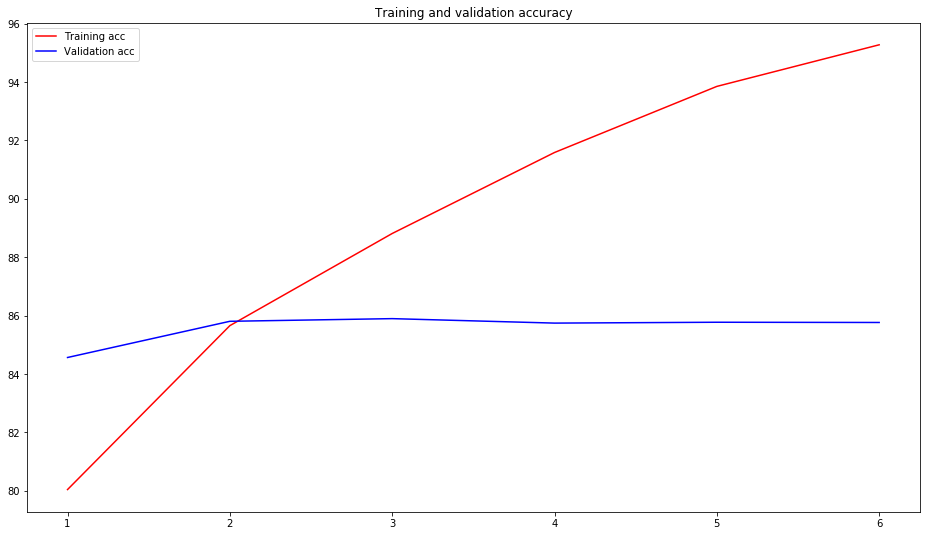

In [48]:
# Accuracy
epochs = range(1, 6 + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

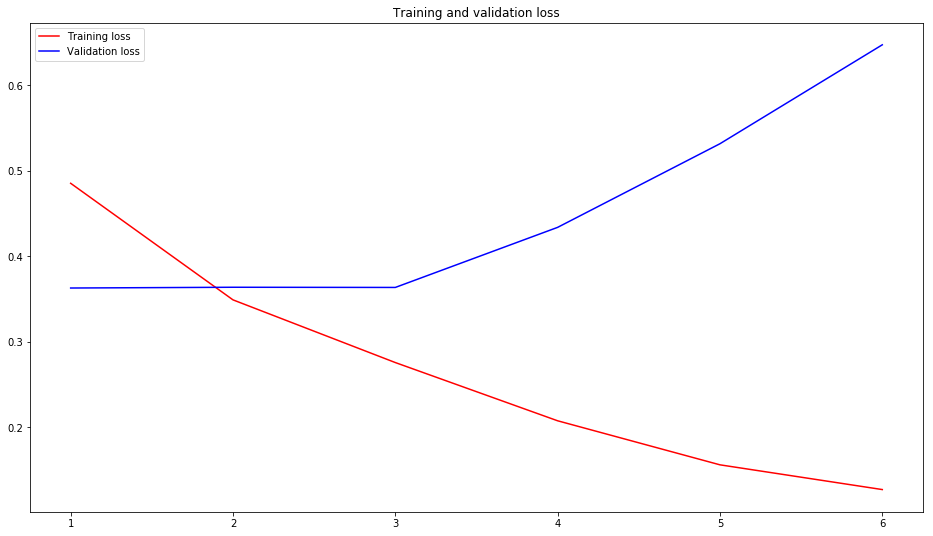

In [49]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluate on validation set

In [50]:
accuracy = 0

for test in val_data:
    pred = model(test[0], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

85.55952796967824


#### Make nice plots

In [51]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS
    
for data in getBatch(50, val_data):
    inputs, targets = pad_to_batch(data)

    y_val_pred = model(inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds

In [52]:
from sklearn.metrics import confusion_matrix

In [57]:
conf_mat = confusion_matrix(Y_VAL.data, Y_VAL_PREDS.data, labels = [0, 1, 2])

In [58]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.93321726 0.01169009 0.05509265]
 [0.02367288 0.84713056 0.12919656]
 [0.08357424 0.09415243 0.82227332]]


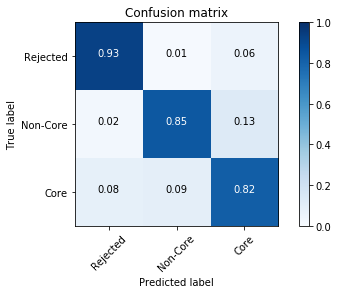

In [59]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

#### Repeat for test data

In [60]:
if 'Y_TEST' in locals():
    del Y_TEST, Y_TEST_PREDS
    
for data in getBatch(50, test_data):
    inputs, targets = pad_to_batch(data)

    y_test_pred = model(inputs, False)
    preds = y_test_pred.max(1)[1]
    
    if 'Y_TEST' in locals():
        Y_TEST = torch.cat((Y_TEST, targets), 0)
        Y_TEST_PREDS = torch.cat((Y_TEST_PREDS, preds), 0)
    else:
        Y_TEST = targets
        Y_TEST_PREDS = preds

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
conf_mat = confusion_matrix(Y_TEST.data, Y_TEST_PREDS.data, labels = [0, 1, 2])

In [63]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.92916516 0.0099988  0.06083604]
 [0.0252809  0.84173566 0.13298344]
 [0.0841085  0.0919144  0.8239771 ]]


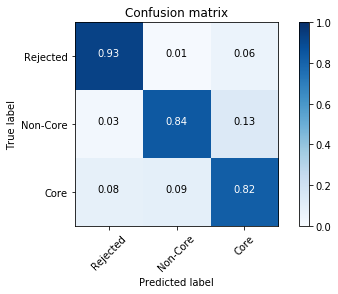

In [64]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()

### Repeat training using 80 - 20 train-val split

In [65]:
X_p, y_p = [], []
for pair in zip(X,y):
    X_p.append(prepare_sequence(pair[0], word2index).view(1, -1))
    y_p.append(Variable(LongTensor([target2index[pair[1]]])).view(1, -1))
    
data_p = list(zip(X_p, y_p))
random.shuffle(data_p)

train_data = data_p[: int(len(data_p) * 0.8)]
val_data = data_p[int(len(data_p) * 0.8):]

In [66]:
model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)

In [67]:
len(model.index2word)

3000000

In [68]:
pretrained = []

for key in word2index.keys():
    try:
        pretrained.append(model[word2index[key]])
    except:
        pretrained.append(np.random.randn(300))
        
pretrained_vectors = np.vstack(pretrained)

In [69]:
EPOCH = 6
BATCH_SIZE = 64
KERNEL_SIZES = [3,4,5,6]
KERNEL_DIM = 200
LR = 0.001

In [70]:
model = CNNClassifier(len(word2index), 300, len(target2index), KERNEL_DIM, KERNEL_SIZES)
model.init_weights(pretrained_vectors) # initialize embedding matrix using pretrained vectors

if USE_CUDA:
    model = model.cuda()
    
loss_function = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [71]:
print(model)

CNNClassifier(
  (embedding): Embedding(282887, 300)
  (convs): ModuleList(
    (0): Conv2d(1, 200, kernel_size=(3, 300), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(4, 300), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(5, 300), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(6, 300), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=800, out_features=3, bias=True)
)


In [72]:
train_loss, train_acc, val_loss, val_acc = [], [], [], []
for epoch in range(EPOCH):
    
#     scheduler.step()
    
    print('<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>')
    epoch_train_loss, epoch_train_acc = train_model(train_data, model, loss_function, epoch)
    print('[TRAIN] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_train_loss, epoch_train_acc))
    train_loss.append(epoch_train_loss)
    train_acc.append(epoch_train_acc)
    
    print('<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>')
    epoch_val_loss, epoch_val_acc = validate(val_data, model, loss_function, epoch)
    print('[VAL] EPOCH: {}, Loss: {}, Accuracy: {}'.format(epoch, epoch_val_loss, epoch_val_acc))    
    val_loss.append(epoch_val_loss)
    val_acc.append(epoch_val_acc)

<<<<<<<<<<<<<TRAINING>>>>>>>>>>>>
TRAIN [Epoch : 0/6][Batch: 0] Batch Train Loss: [1.4623905420303345], Batch Train Accuracy: 21.875
TRAIN [Epoch : 0/6][Batch: 100] Batch Train Loss: [0.7397686243057251], Batch Train Accuracy: 57.8125
TRAIN [Epoch : 0/6][Batch: 200] Batch Train Loss: [0.6144537329673767], Batch Train Accuracy: 78.125
TRAIN [Epoch : 0/6][Batch: 300] Batch Train Loss: [0.5305109024047852], Batch Train Accuracy: 79.6875
TRAIN [Epoch : 0/6][Batch: 400] Batch Train Loss: [0.7213408350944519], Batch Train Accuracy: 70.3125
TRAIN [Epoch : 0/6][Batch: 500] Batch Train Loss: [0.6289648413658142], Batch Train Accuracy: 73.4375
TRAIN [Epoch : 0/6][Batch: 600] Batch Train Loss: [0.5892300605773926], Batch Train Accuracy: 78.125
TRAIN [Epoch : 0/6][Batch: 700] Batch Train Loss: [0.49695953726768494], Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/6][Batch: 800] Batch Train Loss: [0.463302880525589], Batch Train Accuracy: 82.8125
TRAIN [Epoch : 0/6][Batch: 900] Batch Train Loss: [0.

TRAIN [Epoch : 2/6][Batch: 1700] Batch Train Loss: [0.23273801803588867], Batch Train Accuracy: 92.1875
TRAIN [Epoch : 2/6][Batch: 1800] Batch Train Loss: [0.3389826714992523], Batch Train Accuracy: 85.9375
TRAIN [Epoch : 2/6][Batch: 1900] Batch Train Loss: [0.20546874403953552], Batch Train Accuracy: 90.625
TRAIN [Epoch : 2/6][Batch: 2000] Batch Train Loss: [0.28505027294158936], Batch Train Accuracy: 90.625
TRAIN [Epoch : 2/6][Batch: 2100] Batch Train Loss: [0.326116681098938], Batch Train Accuracy: 85.9375
TRAIN [Epoch : 2/6][Batch: 2200] Batch Train Loss: [0.15611249208450317], Batch Train Accuracy: 93.75
TRAIN [Epoch : 2/6][Batch: 2300] Batch Train Loss: [0.23866385221481323], Batch Train Accuracy: 90.625
[TRAIN] EPOCH: 2, Loss: 0.2800513505935669, Accuracy: 88.73669926913156
<<<<<<<<<<<<< VALIDATING >>>>>>>>>>>>
VAL [Epoch : 2/6][Batch: 0] Batch Test Loss: [0.2440955936908722], Batch Test Accuracy: 90.625
VAL [Epoch : 2/6][Batch: 100] Batch Test Loss: [0.30443185567855835], Batch

TRAIN [Epoch : 5/6][Batch: 200] Batch Train Loss: [0.04968564584851265], Batch Train Accuracy: 100.0
TRAIN [Epoch : 5/6][Batch: 300] Batch Train Loss: [0.057037353515625], Batch Train Accuracy: 96.875
TRAIN [Epoch : 5/6][Batch: 400] Batch Train Loss: [0.17904233932495117], Batch Train Accuracy: 93.75
TRAIN [Epoch : 5/6][Batch: 500] Batch Train Loss: [0.03824222460389137], Batch Train Accuracy: 96.875
TRAIN [Epoch : 5/6][Batch: 600] Batch Train Loss: [0.13130611181259155], Batch Train Accuracy: 92.1875
TRAIN [Epoch : 5/6][Batch: 700] Batch Train Loss: [0.13940124213695526], Batch Train Accuracy: 90.625
TRAIN [Epoch : 5/6][Batch: 800] Batch Train Loss: [0.11825788766145706], Batch Train Accuracy: 95.3125
TRAIN [Epoch : 5/6][Batch: 900] Batch Train Loss: [0.07492814213037491], Batch Train Accuracy: 96.875
TRAIN [Epoch : 5/6][Batch: 1000] Batch Train Loss: [0.05316253751516342], Batch Train Accuracy: 98.4375
TRAIN [Epoch : 5/6][Batch: 1100] Batch Train Loss: [0.031555477529764175], Batch T

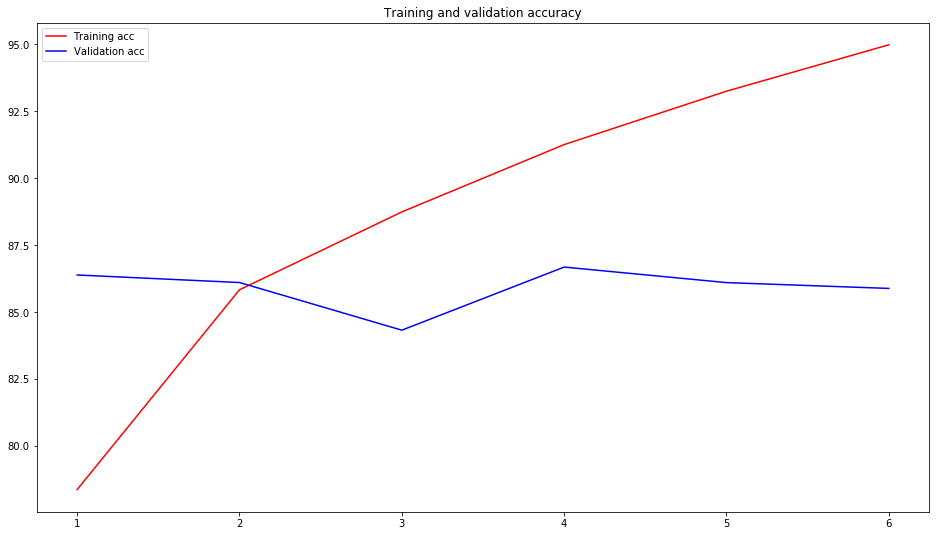

In [73]:
# Accuracy
epochs = range(1, 6 + 1)

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

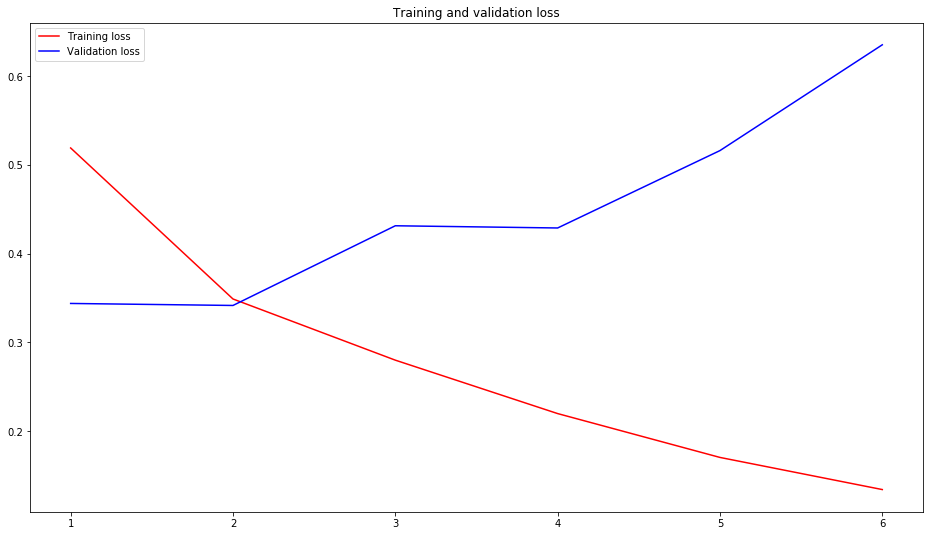

In [74]:
# Loss

plt.figure(figsize=(16, 9))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
accuracy = 0

for test in val_data:
    pred = model(test[0], False).max(1)[1]
    pred = pred.data.tolist()[0]
    target = test[1].data.tolist()[0][0]
    if pred == target:
        accuracy += 1

print(accuracy/len(val_data) * 100)

In [87]:
if 'Y_VAL' in locals():
    del Y_VAL, Y_VAL_PREDS
    
for data in getBatch(50, val_data):
    inputs, targets = pad_to_batch(data)

    y_val_pred = model(inputs, False)
    preds = y_val_pred.max(1)[1]
    
    if 'Y_VAL' in locals():
        Y_VAL = torch.cat((Y_VAL, targets), 0)
        Y_VAL_PREDS = torch.cat((Y_VAL_PREDS, preds), 0)
    else:
        Y_VAL = targets
        Y_VAL_PREDS = preds

In [88]:
from sklearn.metrics import confusion_matrix

In [89]:
conf_mat = confusion_matrix(Y_VAL.data, Y_VAL_PREDS.data, labels = [0, 1, 2])

In [90]:
# funtion to plot confusion matrices, will be needed later

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, vmax=1)
    else:
        print('Confusion matrix, without normalization')
        plt.imshow(cm, interpolation='nearest', cmap=cmap)

    print(cm)
    
    
    plt.title(title)
    plt.colorbar( )
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.89422135 0.01971107 0.08606758]
 [0.01251637 0.86632222 0.1211614 ]
 [0.05754643 0.10685326 0.83560031]]


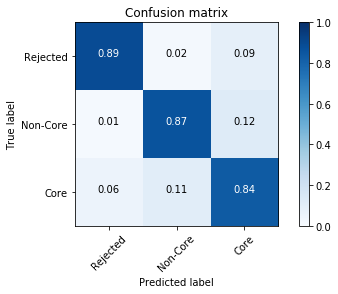

In [91]:
plt.figure()
plot_confusion_matrix(conf_mat, ['Rejected', 'Non-Core', 'Core'], normalize=True)
plt.show()